Collecting the data of vehicle in a dic


In [ ]:
!unzip gdrive/My\ Drive/pcd/vehicles

In [ ]:
!unzip gdrive/My\ Drive/pcd/non-vehicles

In [ ]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import *

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
print('we are good')

we are good


Data info

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: <class 'numpy.uint8'>


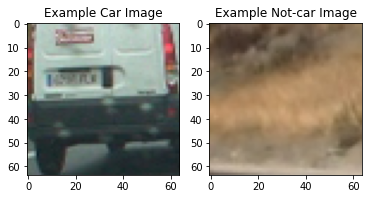

In [ ]:
non_vehicles_gti = glob.glob('/content/non-vehicles/GTI/*.png')
non_vehicles_extras = glob.glob('/content/non-vehicles/Extras/*.png')

vehicles_gti_far = glob.glob('/content/vehicles/GTI_Far/*.png')
vehicles_gti_left = glob.glob('/content/vehicles/GTI_Left/*.png')
vehicles_gti_right = glob.glob('/content/vehicles/GTI_Right/*.png')
vehicles_gti_middle = glob.glob('/content/vehicles/GTI_MiddleClose/*.png')
vehicles_kitti = glob.glob('/content/vehicles/KITTI_extracted/*.png')

notcars = np.concatenate((non_vehicles_gti, non_vehicles_extras))
cars = np.concatenate((vehicles_gti_far, vehicles_gti_left, vehicles_gti_right, vehicles_gti_middle, vehicles_kitti))


def data_look(car_list, notcar_list):
    data_dict = {}
    data_dict["n_cars"] = len(car_list)
    data_dict["n_notcars"] = len(notcar_list)
    test_image = cv2.imread(car_list[0])
    data_dict["image_shape"] = test_image.shape
    data_dict["data_type"] = type(test_image[0][0][0])
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
 
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('output_images/car_no_car', bbox_inches='tight')
plt.show()

a histogram of the RGB values in an imag

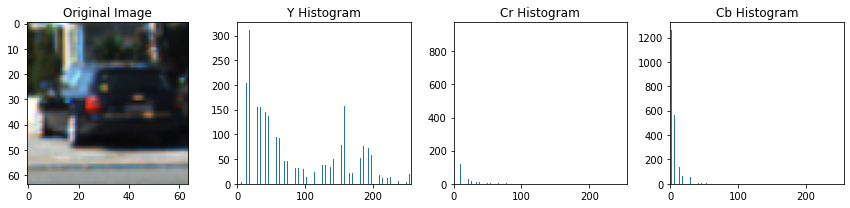

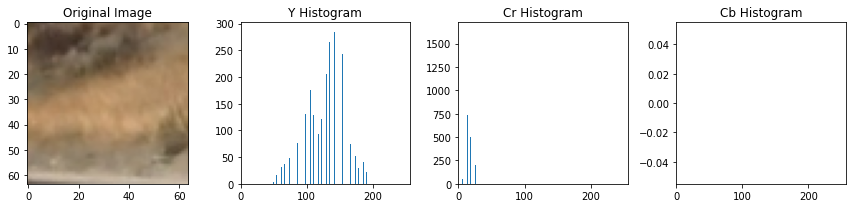

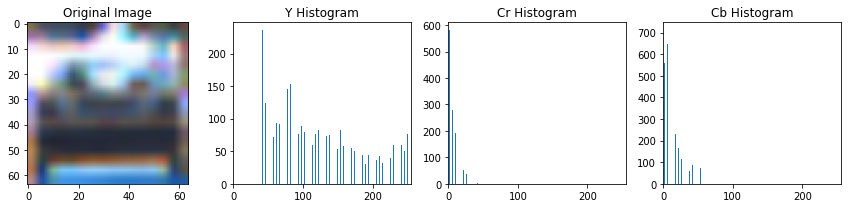

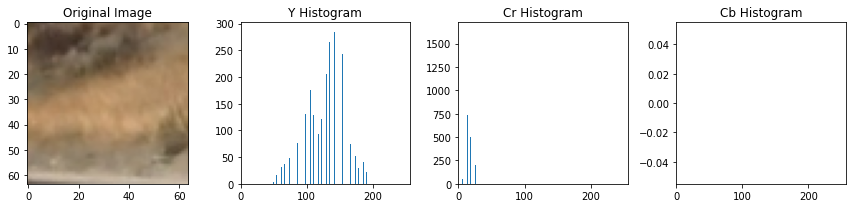

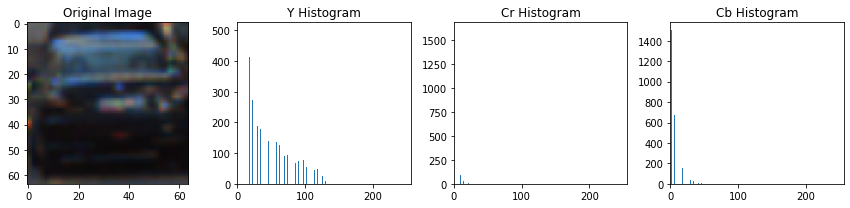

In [ ]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    yhist = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    crhist = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    cbhist = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    
    bin_centers = (yhist[1][1:]  + yhist[1][0:len(yhist[1])-1])/2

    hist_features = np.concatenate((yhist[0], crhist[0], cbhist[0]))

    return yhist, crhist, cbhist, bin_centers, hist_features
    


for i in range(0, 5):
    
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
    else:
        car_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
        
    image = image*255
    
    yh, crh, cbh, bincen, feature_vec = color_hist(image, nbins=64, bins_range=(0, 256))
    if yh is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(141)
        image = image/255
        plt.imshow(image)
        plt.title('Original Image')
        plt.subplot(142)
        plt.bar(bincen, yh[0])
        plt.xlim(0, 256)
        plt.title('Y Histogram')
        plt.subplot(143)
        plt.bar(bincen, crh[0])
        plt.xlim(0, 256)
        plt.title('Cr Histogram')
        plt.subplot(144)
        plt.bar(bincen, cbh[0])
        plt.xlim(0, 256)
        plt.title('Cb Histogram')
        fig.tight_layout()
        plt.savefig('output_images/histogram'+str(i), bbox_inches='tight')
        plt.show()
    else:
        print('Your function is returning None for at least one variable...')

Resing / feature vec

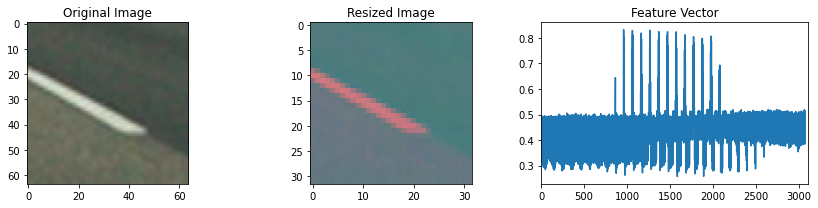

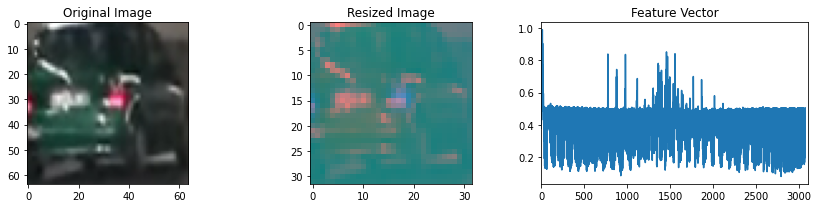

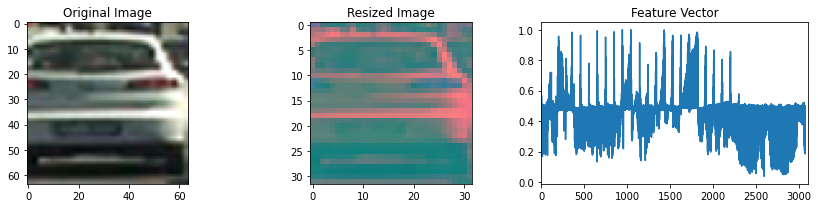

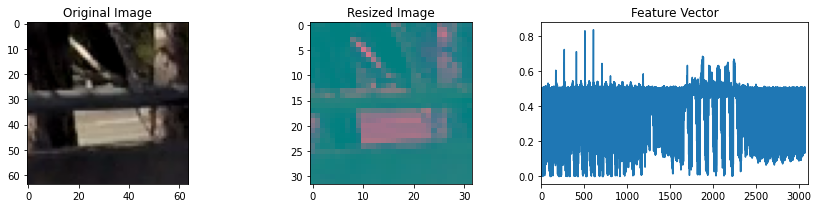

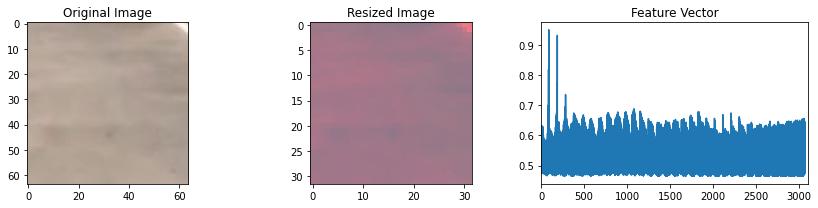

In [ ]:
image = mpimg.imread(notcars[12])


def bin_spatial(img, color_space='RGB', size=(32, 32)):
    if(color_space == 'HSV'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif(color_space == 'LUV'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif(color_space == 'YCrCb'):
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    
    img = cv2.resize(img, size)

    features = img.ravel() 
    return features, img
    
for i in range(5):
    
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
    else:
        notcar_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
    
    feature_vec, resized = bin_spatial(image, color_space='YCrCb', size=(32, 32))


    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(image)
    plt.title('Original Image')
    plt.subplot(132)
    plt.imshow(resized)
    plt.title('Resized Image')
    plt.subplot(133)
    plt.plot(feature_vec)
    plt.xlim(0,3100)
    plt.title('Feature Vector')
    fig.tight_layout()
    plt.savefig('output_images/spatial_feat'+str(i), bbox_inches='tight')
    plt.show()

In [ ]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                        vis=False, feature_vec=True):

    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image

    else:      
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features


hog featr / vizua

NameError: ignored

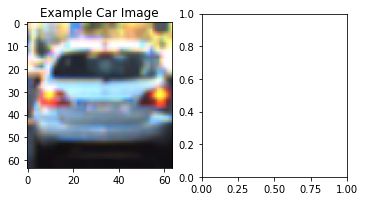

In [ ]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        return hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), cells_per_block = (cell_per_block,cell_per_block), visualize = vis, feature_vector = feature_vec)
    else:      
        return hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell), cells_per_block = (cell_per_block,cell_per_block), visualize = vis, feature_vector = feature_vec)


for i in range(5):
    fig = plt.figure(figsize=(12,3))
    plt.subplot(141)
    if(np.random.random()>0.5):
        car_ind = np.random.randint(0, len(cars))
        image = mpimg.imread(cars[car_ind])
        plt.imshow(image, cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(142)
        plt.imshow(y_hog_image, cmap='gray')
        plt.title('Y HOG Visualization')
        plt.subplot(143)
        plt.imshow(cr_hog_image, cmap='gray')
        plt.title('Cr HOG Visualization')
        plt.subplot(144)
        plt.imshow(cb_hog_image, cmap='gray')
        plt.title('Cb HOG Visualization')
    else:
        notcar_ind = np.random.randint(0, len(notcars))
        image = mpimg.imread(notcars[notcar_ind])
        plt.imshow(image, cmap='gray')
        plt.title('Example Non Car Image')
        plt.subplot(142)
        plt.imshow(y_hog_image, cmap='gray')
        plt.title('Y HOG Visualization')
        plt.subplot(143)
        plt.imshow(cr_hog_image, cmap='gray')
        plt.title('Cr HOG Visualization')
        plt.subplot(144)
        plt.imshow(cb_hog_image, cmap='gray')
        plt.title('Cb HOG Visualization')
    
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
 
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    
    y_features, y_hog_image = get_hog_features(img_ycrcb[:,:,0], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    cr_features, cr_hog_image = get_hog_features(img_ycrcb[:,:,1], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)
    
    cb_features, cb_hog_image = get_hog_features(img_ycrcb[:,:,2], orient, 
                            pix_per_cell, cell_per_block, 
                            vis=True, feature_vec=False)


    plt.savefig('output_images/hog_feat'+str(i), bbox_inches='tight')
    plt.show()

All functions


In [ ]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0] 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    window_list = []

    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, (bbox[0][0], bbox[0][1]), (bbox[1][0],bbox[1][1]), color, thick)
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

Get a trained SVM model for detecting Cars

In [ ]:
def get_trained_model(cars, notcars, color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat, test_size = 0.2):
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    print(X[0].shape)
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
 
    svc = LinearSVC()

    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')

    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    t=time.time()
    
    return svc, X_scaler

Finding Cars on the given scale and vertical bounds

In [ ]:
def find_cars(img, ystart, ystop, color_space, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, spatial_feat, hist_feat, hog_feat):
    
    img = img.astype(np.float32)/255
    
    conv = 'RGB2' + color_space
    
    img_tosearch = img[int(ystart):int(ystop),:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=conv)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    if(hog_feat == True):
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bbox_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            if(hog_feat == True):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))


            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            if(spatial_feat == True):
                spatial_features = bin_spatial(subimg, size=spatial_size)
            
            if(hist_feat == True):
                hist_features = color_hist(subimg, nbins=hist_bins)
            
            if(spatial_feat == True and hist_feat == True and hog_feat == True):
                stacked = np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1)
            elif(spatial_feat == True and hist_feat == True and hog_feat == False):
                stacked = np.hstack((spatial_features, hist_features)).reshape(1, -1)
            elif(spatial_feat == False and hist_feat == True and hog_feat == True):
                stacked = np.hstack((hist_features, hog_features)).reshape(1, -1)
            elif(spatial_feat == False and hist_feat == False and hog_feat == True):
                stacked = np.hstack((hog_features)).reshape(1, -1)
                
            
            test_features = X_scaler.transform(stacked) 
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

Function for showing all the possible bounding boxes for given range of scales

In [ ]:
def search_windows(img, min_scale, max_scale, no_of_scales, pix_per_cell, cell_per_block):
    
    img = img.astype(np.float32)/255
    conv = 'RGB2YCrCb'
    
    scales = np.arange(min_scale, max_scale, ((max_scale-min_scale)/no_of_scales))
    y_start_stops = []
    for scale in scales:
        y_start_stops.append([400, 400+1.5*scale*64])
    
    bbox_list = []
    for scale, y_start_stop in zip(scales, y_start_stops):
        ystart = y_start_stop[0]
        ystop = y_start_stop[1]
        img_tosearch = img[int(ystart):int(ystop),:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv=conv)
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]

        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell
                
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))

    return bbox_list

Showing all the possible bounding boxes

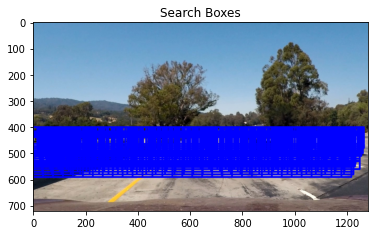

In [ ]:
image = mpimg.imread('test_images/test1.jpg')
boxes = search_windows(image, min_scale=1.0, max_scale=2.5, no_of_scales=12, pix_per_cell=8, cell_per_block=2)
image = draw_boxes(image, boxes)
plt.imshow(image)
plt.title('Search Boxes')
plt.savefig('output_images/search_boxes', bbox_inches='tight')
plt.show()

Heatmap Functions

In [ ]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img